# Supervised Fine-Tuning (SFT): QLoRA with Explicit EOS Tokens

This notebook is an experiment building on the previous QLoRA fine-tuning. The key difference is the data preparation step.

### **Objective:**
- Investigate if explicitly teaching the model when to stop generating improves response quality and reduces rambling.
- **Method:** We add a special End-Of-Sequence (`<|endoftext|>`) token to the end of every "completion" in the training and test datasets before starting the QLoRA training process.

In [46]:
# !pip install transformers==4.43.4
# !pip install torch
# # !pip install trl
# !pip install trl==0.11
# !pip install peft
# !pip install --upgrade tqdm
# !pip install -U bitsandbytes
# !pip install --upgrade jinja2

In [47]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig
from trl import SFTTrainer

In [48]:
from prepare_data import get_sft_datasets

In [49]:
train_dataset, test_dataset = get_sft_datasets(dataset_name='my-local-dataset/')

Loading and processing dataset
Dataset split into 31485 training examples and 1658 testing examples.
Dataset processing complete.


In [50]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

In [51]:
def add_eos_token(sample):
    sample["completion"] = sample["completion"] + tokenizer.eos_token
    return sample

In [52]:
train_dataset = train_dataset.map(add_eos_token)
test_dataset = test_dataset.map(add_eos_token)

In [53]:
print("\n--- Train Set Verification ---")
print(f"Train dataset size: {len(train_dataset)} examples")
print("Features:", train_dataset.features)
print("\nPROMPT:", train_dataset[0]['prompt'])
print("COMPLETION:", train_dataset[0]['completion'])
    
print("\n--- Test Set Verification ---")
print(f"Test dataset size: {len(test_dataset)} examples")
print("Features:", test_dataset.features)
print("\nPROMPT:", test_dataset[0]['prompt'])
print("COMPLETION:", test_dataset[0]['completion'])


--- Train Set Verification ---
Train dataset size: 31485 examples
Features: {'prompt': Value(dtype='string', id=None), 'completion': Value(dtype='string', id=None)}

PROMPT: ### Instruction:
What are some tips for developing a better mental attitude towards difficult tasks.

### Response:

COMPLETION: Break difficult tasks down into manageable pieces. 
2. Take things one step at a time and reward yourself for small accomplishments. 
3. Visualize yourself succeeding in the task. 
4. Focus on the process rather than the outcome. 
5. Remind yourself that you are capable of completing the task.
6. Believe in yourself and your ability to find new solutions to problems. 
7. Give yourself positive affirmations and build a positive mindset.
8. Eliminate distractions and prioritize meaningful tasks. 
9. Take time to refocus and regroup when necessary. 
10. Surround yourself with positive people who will help you stay focused on your goals.<|endoftext|>

--- Test Set Verification ---
Test datas

In [54]:
train_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 31485
})

In [55]:
test_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1658
})

In [56]:
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU count: 1
GPU name: NVIDIA A10G


In [57]:
# Model and tokenizer names
model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token 

In [58]:
tokenizer.eos_token

'<|endoftext|>'

In [59]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [60]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.use_cache = False # Disable caching for training

In [65]:
lora_config = LoraConfig(
    r=16,                
    lora_alpha=32,       
    target_modules=["c_attn"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [29]:
training_args = TrainingArguments(
    output_dir="./sft_results_2",
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    logging_steps=50,
    logging_first_step=True,
    eval_strategy="steps",      
    eval_steps=500,             
    save_steps=500,             
    save_total_limit=2,         
    load_best_model_at_end=True
)

In [30]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_args,
    max_seq_length=1024,
)

##  Start training

In [31]:
trainer.train(resume_from_checkpoint='sft_results/checkpoint-5904/')

Step,Training Loss,Validation Loss
6000,1.951500,1.852630
6500,1.974800,1.847742
7000,1.959700,1.845950
7500,1.956800,1.842180


TrainOutput(global_step=7872, training_loss=0.4915966784081808, metrics={'train_runtime': 415.7917, 'train_samples_per_second': 302.892, 'train_steps_per_second': 18.933, 'total_flos': 1.1323868512720896e+16, 'train_loss': 0.4915966784081808, 'epoch': 4.0})

In [32]:
trainer.save_model("./peft_sft_final_checkpoint_2")
tokenizer.save_pretrained("./peft_sft_final_checkpoint_2")

('./peft_sft_final_checkpoint_2/tokenizer_config.json',
 './peft_sft_final_checkpoint_2/special_tokens_map.json',
 './peft_sft_final_checkpoint_2/vocab.json',
 './peft_sft_final_checkpoint_2/merges.txt',
 './peft_sft_final_checkpoint_2/added_tokens.json',
 './peft_sft_final_checkpoint_2/tokenizer.json')

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nLoading base gpt2 model...")
base_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
base_tokenizer = AutoTokenizer.from_pretrained("gpt2")

print("Loading PEFT fine-tuned SFT model...")
sft_model = AutoModelForCausalLM.from_pretrained("./peft_sft_final_checkpoint_2").to(device)
sft_tokenizer = AutoTokenizer.from_pretrained("./peft_sft_final_checkpoint_2")


Loading base gpt2 model...
Loading PEFT fine-tuned SFT model...


In [38]:
def generate_response(model, tokenizer, prompt_text):
    """
    Generates a response from a given model and tokenizer.
    """
    
    formatted_prompt = f"### Instruction:\n{prompt_text}\n\n### Response:\n"
    
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            temperature=0.7,  
            do_sample=True, 
        )
    
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_response[len(formatted_prompt):].strip()

In [41]:
def evaluate_models(prompt, ground_truth, models):
    print("\n" + "="*60)
    print(" PERFORMANCE COMPARISON ".center(60, "="))
    print("="*60)

    print(f"\nPROMPT:\n{prompt}\n")
    print(f"GROUND TRUTH:\n{ground_truth}\n")

    for name, model, tokenizer in models:
        print(f"\n--- {name.upper()} RESPONSE ---")
        response = generate_response(model, tokenizer, prompt)
        print(response)

    print("\n" + "="*60)

models_to_compare = [
    ("Base Model (GPT-2)", base_model, base_tokenizer),
    ("PEFT SFT Model", sft_model, sft_tokenizer),
]

In [42]:
idx = 10
prompt = test_dataset[idx]["prompt"]
ground_truth = test_dataset[idx]["completion"]


evaluate_models(prompt, ground_truth, models_to_compare)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



================== PERFORMANCE COMPARISON ==================

PROMPT:
### Instruction:
What is the best way to clean and care for leather shoes.

### Response:


GROUND TRUTH:
The best way to clean and care for leather shoes is to start by using a leather cleaner specifically designed for the type of leather used. This will not only help keep them clean, but also help protect the leather from the elements. Once cleaned, apply a leather conditioner to help keep the leather soft and supple. Finally, use a leather polish to help add luster and protection. Reapply the products every couple of months to keep your shoes looking their best.<|endoftext|>


--- BASE MODEL (GPT-2) RESPONSE ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the best way to prevent the loss of leather shoes.

### Response:


### Response:

What are the best ways to prevent the loss of leather shoes in the home.

### Response:


### Response: What is the best way to prevent the loss of leather shoes when you're not in the house.

### Response:


### Response: What is the best way to prevent the loss of leather shoes when you're in a room with a door that's not locked.

### Response:


### Response: What is the best way to prevent the loss of leather shoes when you're on the property and not in your home.

### Response:


### Response: What is the best way to prevent the loss of leather shoes when you're on the property when your house has no locks.

### Response:


### Response: What is the best way to prevent the loss of leather shoes when you're in a room with a locked door.

### Response:


### Response: What is the best way to prevent the loss of leather shoes when you're having your furniture turned on when your home is full of

In [43]:
idx = 20
prompt = test_dataset[idx]["prompt"]
ground_truth = test_dataset[idx]["completion"]


evaluate_models(prompt, ground_truth, models_to_compare)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



================== PERFORMANCE COMPARISON ==================

PROMPT:
### Instruction:
I want to shop for a new car. What should I look for in price, features, and safety.

### Response:


GROUND TRUTH:
For price, look for a car that fits your budget. Consider the total cost, including maintenance, registration, and insurance. When it comes to features, think about what is most important to you. Do you need a lot of cargo space? Or are you looking for the latest technology? When it comes to safety, look for a car with the latest safety features, like lane-keeping assist, adaptive cruise control, and blind spot monitoring. Additionally, consider the car’s ratings in crash tests and look for features like airbags, anti-lock brakes, and anti-theft systems.<|endoftext|>


--- BASE MODEL (GPT-2) RESPONSE ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I want to buy a new car. What should I look for in price, features, and safety.

### Response:


### Response:

I want to make the car more comfortable. What should I look for in price, features, and safety.

### Response:


### Response:

I want to make the car more comfortable. What should I look for in price, features, and safety.

### Response:


### Response:

I want to buy a new car. What should I look for in price, features, and safety.

### Response:


### Response:

I want to make the car more comfortable. What should I look for in price, features, and safety.

### Response:


### Response:

I want to make the car more comfortable. What should I look for in price, features, and safety.

### Response:


### Response:

I want to make the car more comfortable. What should I look for in price, features, and safety.

### Response:


### Response:

I want to make the car more comfortable. What should I look for in price, features, and safety.

### Response:


### Response:

I want t

In [44]:
import json
import matplotlib.pyplot as plt

log_file = "sft_results_2/checkpoint-7872/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# --- Prepare lists to store all metrics ---
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

# --- Iterate through the log history and extract all data ---
for log in logs["log_history"]:
    if "loss" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
    
    elif "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_losses.append(log["eval_loss"])

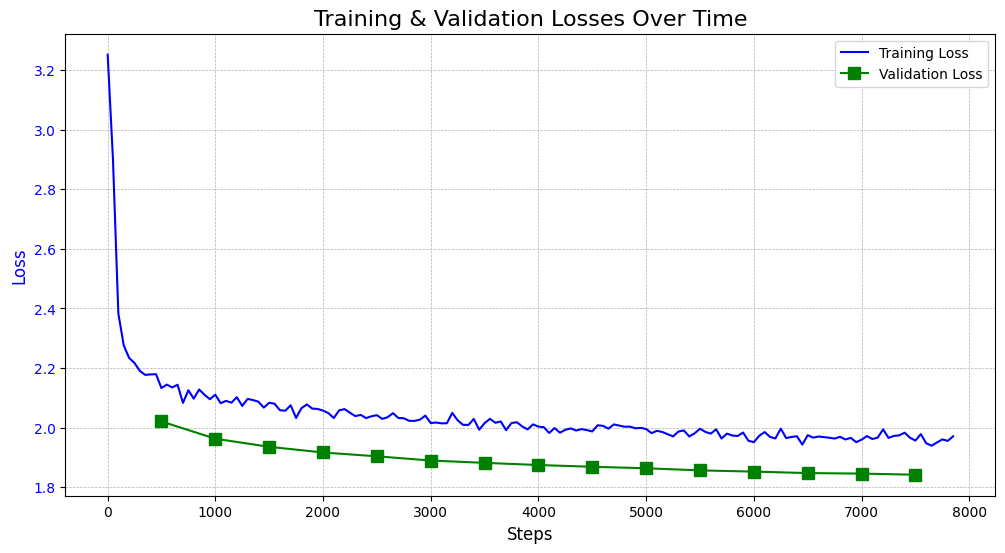

In [45]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(train_steps, train_losses, 'b-', label="Training Loss")
ax1.plot(eval_steps, eval_losses, 'g-s', label="Validation Loss", markersize=8) 
ax1.set_xlabel("Steps", fontsize=12)
ax1.set_ylabel("Loss", color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title("Training & Validation Losses Over Time", fontsize=16)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right')

plt.show()

In [63]:
from peft import get_peft_model

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [64]:
print("--- Base Model Parameters ---")
print_trainable_parameters(base_model)

--- Base Model Parameters ---
trainable params: 124439808 || all params: 124439808 || trainable%: 100.00


In [67]:
peft_model = get_peft_model(base_model, lora_config)

print("\n--- PEFT Model Parameters ---")
print_trainable_parameters(peft_model)


--- PEFT Model Parameters ---
trainable params: 589824 || all params: 125029632 || trainable%: 0.47
